Número de comp PCA: 30
previstos:  [1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1
 0 0 1 0 0]
y_test   :  [1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1
 1 0 1 0 1]


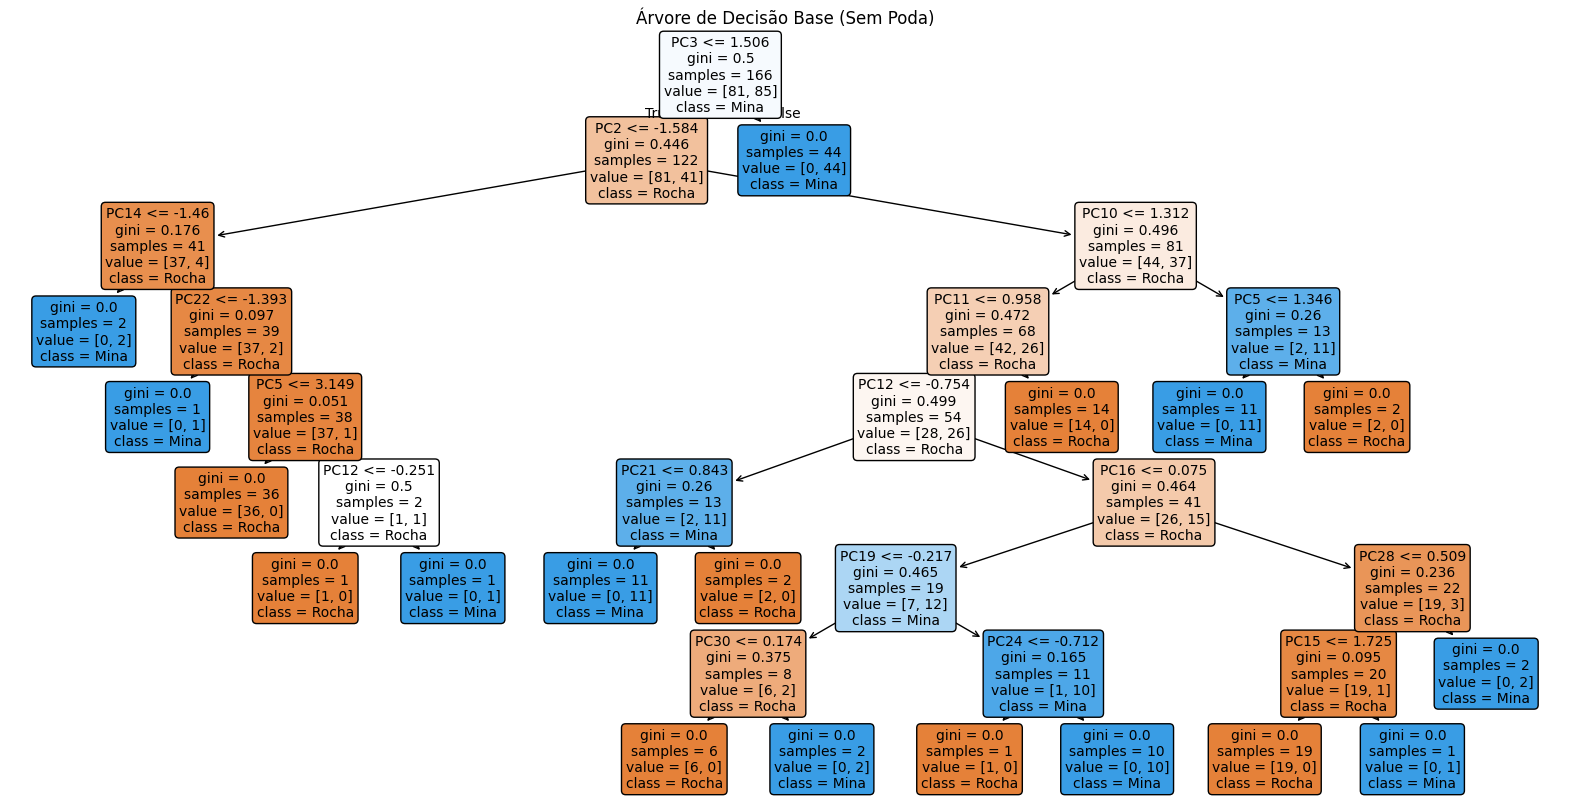

F1-score médio (validação cruzada): 0.6095
Melhores parâmetros encontrados:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}
Parâmetros da árvore podada:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


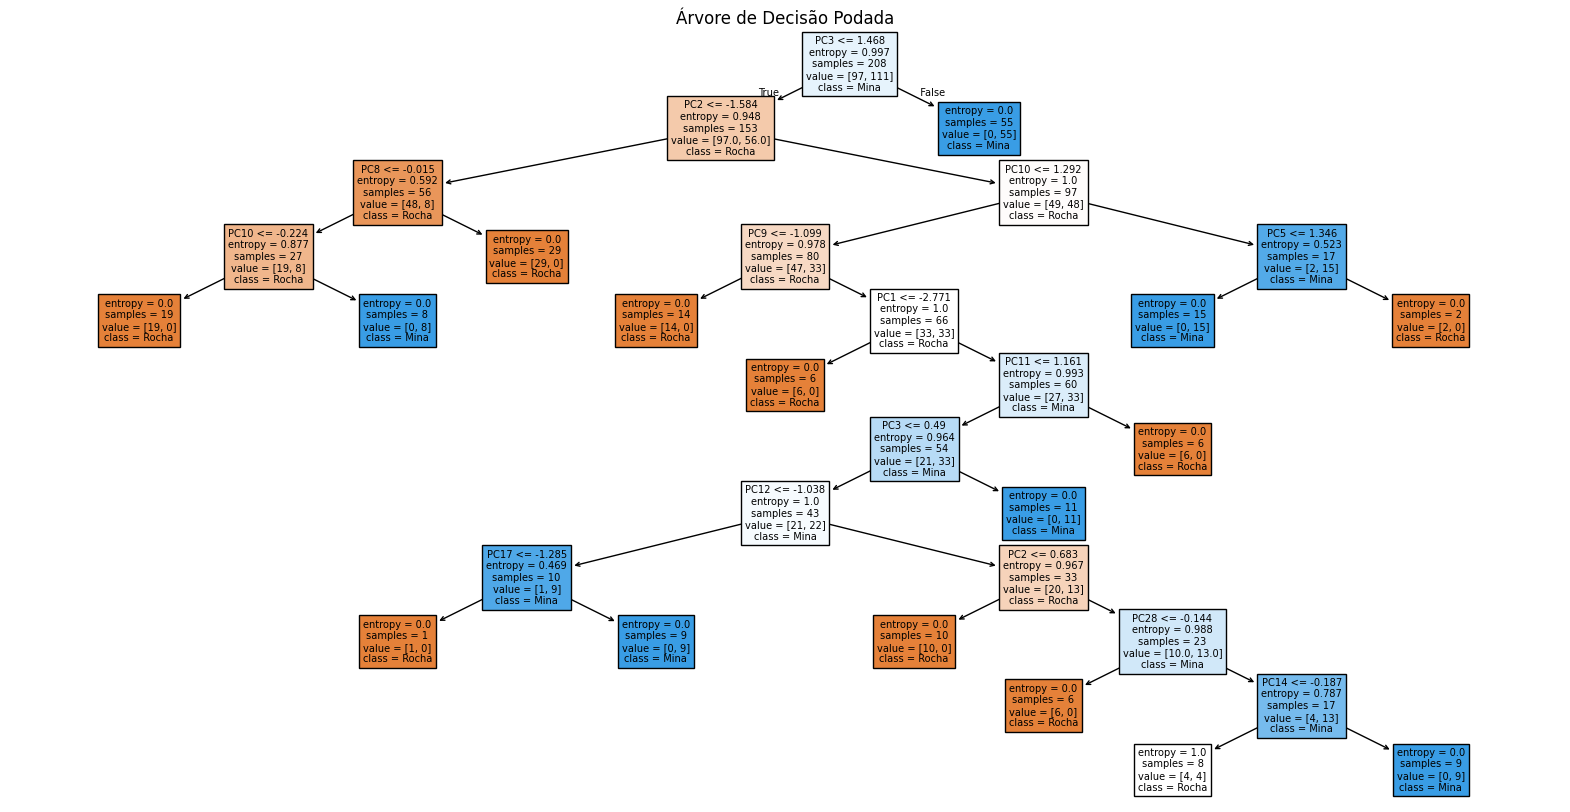

Métricas de Avaliação:
Accuracy:  0.9762
Precisão:  1.0000
Recall:    0.9615
F1-score:  0.9804
Sensibilidade: 0.9615
Especificidade: 1.0000


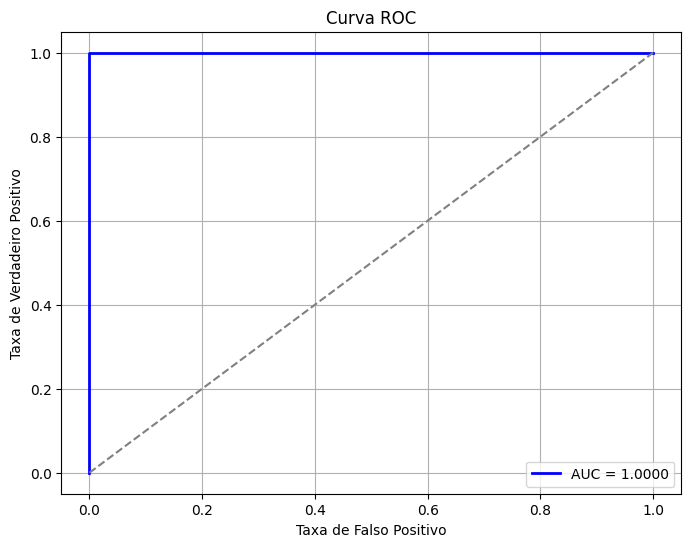

In [ ]:
# Etapa 0 – Imports e Carregamento dos Dados

import pandas as pd
import numpy as np

# t
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

# Carregando os dados
df = pd.read_csv("sonar_dataset.csv", header=None)

# Separando features e rótulos
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Convertendo rótulos para valores binários
y = np.where(y == 'M', 1, 0)  # M: 1 (mina), R: 0 (rocha)

# ------------------------------------------------------------
# Etapa 1 – Normalização e Redução de Dimensionalidade com PCA

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)  # Mantém 95% da variância
X_pca = pca.fit_transform(X_scaled)
print(f"Número de comp PCA: {X_pca.shape[1]}")

# ------------------------------------------------------------
# Etapa 2 – Criação do Modelo de Árvore de Decisão

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Modelo base
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Visualizar
previstos = clf.predict(X_test)
print("previstos: ", previstos)
print("y_test   : ", y_test)

plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    filled=True,
    feature_names=[f"PC{i+1}" for i in range(X_pca.shape[1])],
    class_names=["Rocha", "Mina"],
    rounded=True,
    fontsize=10
)
plt.title("Árvore de Decisão Base (Sem Poda)")
plt.show()

# ------------------------------------------------------------
# Etapa 3 – Validação Cruzada

cv_scores = cross_val_score(clf, X_pca, y, cv=5, scoring='f1')
print(f"F1-score médio (validação cruzada): {cv_scores.mean():.4f}")

# ------------------------------------------------------------
# Etapa 4 – GridSearch para Otimização de Hiperparâmetros

# Criterion: qualidade da divisão da árvore (impureza Gini ou entropia)

# Poda
# Max_Depth: profundidade máxima da árvore. None = sem limite
# Min_Samples_Split: número mínimo de amostras necessárias para dividir um nó interno
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# testa todas as combinações possíveis dos parâmetros definidos, usando validação cruzada de 10 folds
# e seleciona o modelo com melhor F1-score médio
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring='f1'
)

# Treina o modelo em cima dos dados com PCA reduzido
grid_search.fit(X_pca, y)

print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor classificador treinado
best_model = grid_search.best_estimator_

# ------------------------------------------------------------
# Etapa 5 – Pruning (Poda) da Árvore

# best_model já foi treinada com os melhores parâmetros que incluem poda
print("Parâmetros da árvore podada:")
print(best_model.get_params())

# Visualização da árvore podada
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=[f"PC{i+1}" for i in range(X_pca.shape[1])], class_names=["Rocha", "Mina"])
plt.title("Árvore de Decisão Podada")
plt.show()

# Definindo como modelo final
final_model = best_model

# ------------------------------------------------------------
# Etapa 6 – Avaliação Final com Métricas

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("Métricas de Avaliação:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão:  {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
especificidade = tn / (tn + fp)
print(f"Sensibilidade: {recall_score(y_test, y_pred):.4f}") # sensibilidade = recall
print(f"Especificidade: {especificidade:.4f}") # TN / (TN + FP)

# Curva ROC

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Linha base diagonal!
plt.title("Curva ROC")
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
